In [ ]:
import pandas as pd          # data manipulation
import numpy as np           # numerical computing
import matplotlib.pyplot as plt  # plotting
import seaborn as sns        # statistical plots

from sklearn.model_selection import train_test_split   # train/test split
from sklearn.preprocessing import StandardScaler       # feature scaling
from sklearn.linear_model import LogisticRegression    # logistic model
from sklearn.metrics import (                          # evaluation metrics
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)

import statsmodels.api as sm  # statistical modeling (logit with p-values)

plt.rcParams["font.family"] = "DejaVu Sans"  # avoid font issues

In [ ]:
#read data and quick view
CPBL_data = pd.read_excel("CPBL_hitter.xlsx")  # read hitter data

CPBL_data.head()  # show first few rows

,球員,隊伍,背號,PA,AVG,OBP,SLG,ISO,BABIP,BIP%,OPS,OPS+,tOPS+,RC,wOBA,BB%,BB/K,K%,PutAway%
0,黃韋盛,中信兄弟,66,314,0.282,0.331,0.363,0.081,0.355,70.5,0.694,104.2,104.3,34.1,0.311,6.7,0.318,21.0,38.6
1,王威晨,中信兄弟,9,338,0.289,0.338,0.341,0.051,0.337,78.3,0.679,100.3,100.2,36.1,0.308,7.1,0.500,14.2,26.8
2,許基宏,中信兄弟,74,379,0.280,0.377,0.506,0.226,0.323,58.8,0.884,158.4,159.0,59.4,0.380,11.6,0.518,22.4,44.0
3,陳俊秀,中信兄弟,29,223,0.241,0.336,0.361,0.120,0.284,66.4,0.698,105.2,105.3,22.7,0.316,11.2,0.595,18.8,36.5
4,曾頌恩,中信兄弟,1,208,0.219,0.303,0.279,0.060,0.257,73.1,0.582,72.1,71.9,15.4,0.269,10.1,0.656,15.4,31.4


In [ ]:
#info and missing values
CPBL_data.info()        # column types and non-null counts
CPBL_data.isna().sum()  # count missing values per column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   球員        163 non-null    object 
 1   隊伍        163 non-null    object 
 2   背號        163 non-null    int64  
 3   PA        163 non-null    int64  
 4   AVG       163 non-null    float64
 5   OBP       163 non-null    float64
 6   SLG       163 non-null    float64
 7   ISO       163 non-null    float64
 8   BABIP     161 non-null    float64
 9   BIP%      163 non-null    float64
 10  OPS       163 non-null    float64
 11  OPS+      163 non-null    float64
 12  tOPS+     163 non-null    float64
 13  RC        163 non-null    float64
 14  wOBA      163 non-null    float64
 15  BB%       163 non-null    float64
 16  BB/K      160 non-null    float64
 17  K%        163 non-null    float64
 18  PutAway%  163 non-null    float64
dtypes: float64(15), int64(2), object(2)
memory usage: 24.3+ KB


球員          0
隊伍          0
背號          0
PA          0
AVG         0
OBP         0
SLG         0
ISO         0
BABIP       2
BIP%        0
OPS         0
OPS+        0
tOPS+       0
RC          0
wOBA        0
BB%         0
BB/K        3
K%          0
PutAway%    0
dtype: int64

/opt/miniconda3/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/miniconda3/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


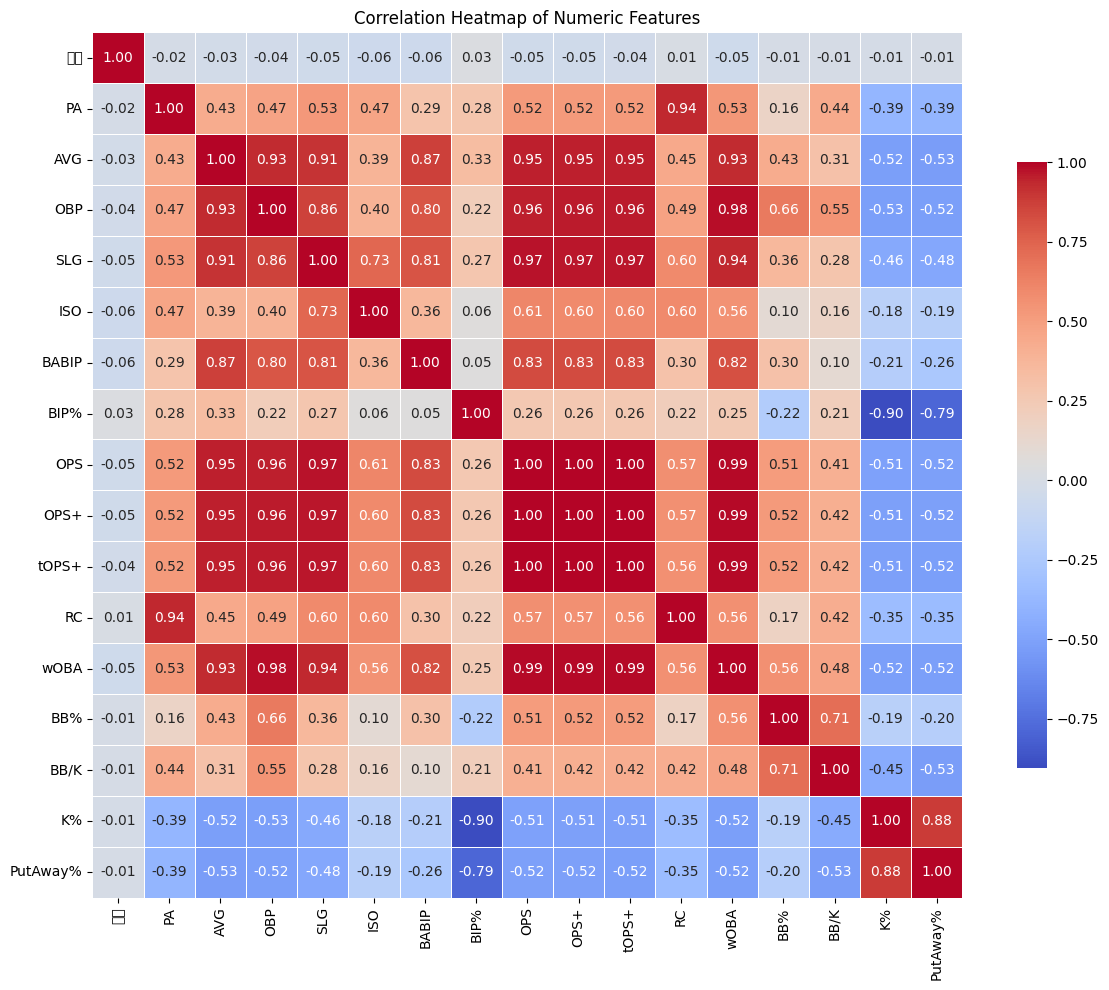

In [5]:
# correlation heatmap for numeric columns
num_cols = CPBL_data.select_dtypes(include=[np.number]).columns.tolist()  # numeric cols
df_num = CPBL_data[num_cols].copy()                                       # numeric-only df

corr = df_num.corr()  # correlation matrix

plt.figure(figsize=(12, 10))  # set figure size
sns.heatmap(
    corr,
    annot=True,        # show numbers
    fmt=".2f",         # two decimals
    cmap="coolwarm",   # color map
    linewidths=0.5,    # line width between cells
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [15]:
# create elite label using OPS+
df = CPBL_data[CPBL_data["PA"] >= 50].copy()  # filter players with enough PA

df = df.rename(columns={          # rename columns
    "OPS+": "OPS_plus",
    "BB%": "BB_pct",
    "K%": "K_pct",
    "BIP%": "BIP_pct",
    "PutAway%": "PutAway_pct",
})

cutoff = 110                      # threshold for elite hitters
df["elite"] = (df["OPS_plus"] >= cutoff).astype(int)  # 1 = elite, 0 = non-elite

df[["球員", "隊伍", "PA", "OPS_plus", "elite"]].head()  # check new label

,球員,隊伍,PA,OPS_plus,elite
0,黃韋盛,中信兄弟,314,104.2,0
1,王威晨,中信兄弟,338,100.3,0
2,許基宏,中信兄弟,379,158.4,1
3,陳俊秀,中信兄弟,223,105.2,0
4,曾頌恩,中信兄弟,208,72.1,0


In [16]:
# feature selection and train/test split
feature_cols = [          # process-based features only
    "PA",          # opportunities
    "BB_pct",      # walk rate
    "K_pct",       # strikeout rate
    "BABIP",       # batting average on balls in play
    "BIP_pct",     # balls in play rate
    "PutAway_pct", # put-away rate in 2-strike counts
]

df_model = df.dropna(subset=feature_cols + ["elite"]).copy()

X = df_model[feature_cols]        # feature matrix
y = df_model["elite"]             # target vector

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((70, 6), (30, 6))

==== Logistic Regression (sklearn) ====
Train accuracy: 0.9
Test  accuracy: 0.7333333333333333

Confusion matrix (test):
[[20  1]
 [ 7  2]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.741     0.952     0.833        21
           1      0.667     0.222     0.333         9

    accuracy                          0.733        30
   macro avg      0.704     0.587     0.583        30
weighted avg      0.719     0.733     0.683        30


Test AUC: 0.9153439153439153


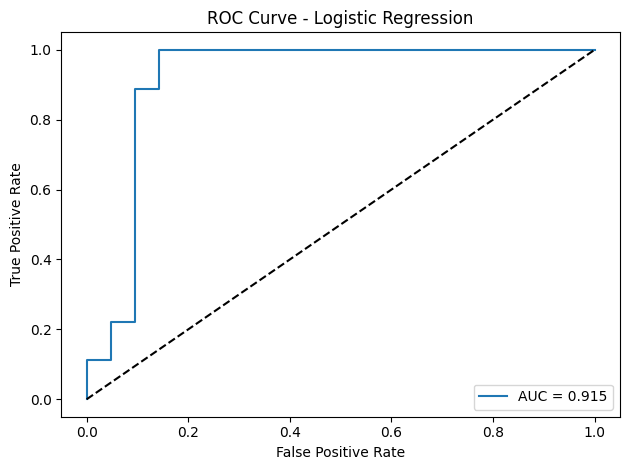

In [17]:
# logistic regression with sklearn (ML style)
log_clf = LogisticRegression(max_iter=1000)  # create model
log_clf.fit(X_train_scaled, y_train)         # fit model on training data

y_train_pred = log_clf.predict(X_train_scaled)  # train predictions
y_test_pred = log_clf.predict(X_test_scaled)    # test predictions

print("==== Logistic Regression (sklearn) ====")
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test  accuracy:", accuracy_score(y_test, y_test_pred))

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

y_test_prob = log_clf.predict_proba(X_test_scaled)[:, 1]  # predicted probabilities
auc = roc_auc_score(y_test, y_test_prob)
print("\nTest AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# full statsmodels logit with all process-based features

# use the same process-based feature set as sklearn
feature_cols_sm_full = [
    "PA",
    "BB_pct",
    "K_pct",
    "BABIP",
    "BIP_pct",
    "PutAway_pct",
]

X_sm_full = df_model[feature_cols_sm_full].copy()   # feature matrix (full)
y_sm = df_model["elite"].copy()                     # target vector

# standardize features (mean 0, std 1)
X_sm_full_scaled = (X_sm_full - X_sm_full.mean()) / X_sm_full.std(ddof=0)

# add intercept term
X_sm_full_const = sm.add_constant(X_sm_full_scaled)

print("Full design matrix shape:", X_sm_full_const.shape)

# build and fit full logit model
logit_model_full = sm.Logit(y_sm, X_sm_full_const)
logit_result_full = logit_model_full.fit(disp=False)

print(logit_result_full.summary())

Full design matrix shape: (100, 7)
                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:                  100
Model:                          Logit   Df Residuals:                       93
Method:                           MLE   Df Model:                            6
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.6385
Time:                        00:58:23   Log-Likelihood:                -21.766
converged:                       True   LL-Null:                       -60.215
Covariance Type:            nonrobust   LLR p-value:                 1.559e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1896      0.809     -3.942      0.000      -4.776      -1.604
PA              0.9739      0.539      1.807      0.071      -0.083       2.030
BB_pct       

In [20]:
# reduced statsmodels logit after inspecting p-values

# choose reduced feature set based on full-model p-values
feature_cols_sm = [
    "PA",
    "K_pct",
    "BABIP",
    "BIP_pct",
]

X_sm = df_model[feature_cols_sm].copy()   # reduced feature matrix
y_sm = df_model["elite"].copy()           # target vector

# standardize features (mean 0, std 1)
X_sm_scaled = (X_sm - X_sm.mean()) / X_sm.std(ddof=0)

# add intercept term
X_sm_const = sm.add_constant(X_sm_scaled)

print("Reduced design matrix shape:", X_sm_const.shape)

# build and fit reduced logit model
logit_model = sm.Logit(y_sm, X_sm_const)
logit_result = logit_model.fit(disp=False)

print(logit_result.summary())

Reduced design matrix shape: (100, 5)
                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.6141
Time:                        01:00:04   Log-Likelihood:                -23.237
converged:                       True   LL-Null:                       -60.215
Covariance Type:            nonrobust   LLR p-value:                 3.313e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1456      0.786     -4.000      0.000      -4.687      -1.604
PA             0.9158      0.498      1.839      0.066      -0.060       1.892
K_pct         

In [21]:
# odds ratios and confidence intervals for reduced logit
params = logit_result.params
conf_int = logit_result.conf_int()
conf_int.columns = ["2.5%", "97.5%"]

odds_ratios = np.exp(params)
odds_conf = np.exp(conf_int)

summary_table_sm = pd.DataFrame({
    "coef": params,
    "odds_ratio": odds_ratios,
    "CI_2.5%": odds_conf["2.5%"],
    "CI_97.5%": odds_conf["97.5%"],
})

summary_table_sm

,coef,odds_ratio,CI_2.5%,CI_97.5%
const,-3.145606,0.043041,0.009216,0.201001
PA,0.915778,2.498718,0.941380,6.632385
K_pct,-4.398354,0.012298,0.000926,0.163367
BABIP,3.578202,35.809108,7.134273,179.736919
BIP_pct,-4.228280,0.014577,0.001283,0.165566


=== Reduced Logit (statsmodels) - Full Sample ===
Accuracy: 0.89

Confusion matrix:
[[66  5]
 [ 6 23]]

Classification report:
              precision    recall  f1-score   support

           0      0.917     0.930     0.923        71
           1      0.821     0.793     0.807        29

    accuracy                          0.890       100
   macro avg      0.869     0.861     0.865       100
weighted avg      0.889     0.890     0.889       100


AUC (full sample): 0.9601748421563866


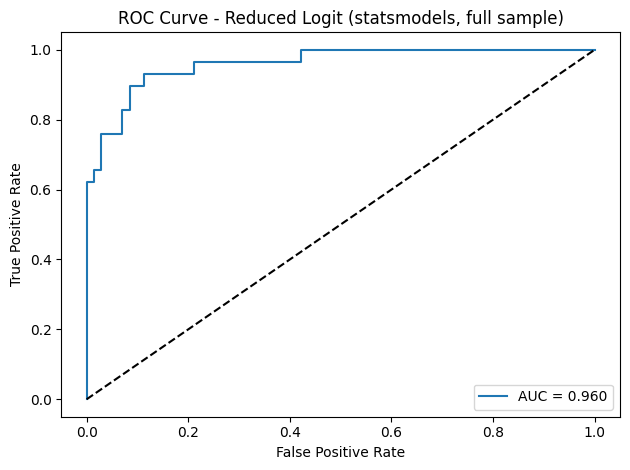

In [24]:
# evaluate reduced statsmodels logit on full sample

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# predicted probabilities and labels
y_prob_full = logit_result.predict(X_sm_const)              # P(elite=1 | X)
y_pred_full = (y_prob_full >= 0.5).astype(int)              # 0.5 threshold

# basic metrics (in-sample)
acc_full = accuracy_score(y_sm, y_pred_full)
cm_full = confusion_matrix(y_sm, y_pred_full)

print("=== Reduced Logit (statsmodels) - Full Sample ===")
print("Accuracy:", acc_full)
print("\nConfusion matrix:")
print(cm_full)

print("\nClassification report:")
print(classification_report(y_sm, y_pred_full, digits=3))

# AUC and ROC curve
auc_full = roc_auc_score(y_sm, y_prob_full)
print("\nAUC (full sample):", auc_full)

fpr_full, tpr_full, thr_full = roc_curve(y_sm, y_prob_full)
plt.figure()
plt.plot(fpr_full, tpr_full, label=f"AUC = {auc_full:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Reduced Logit (statsmodels, full sample)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# feature selection and train/test split with final 4 features
feature_cols = [
    "PA",
    "K_pct",
    "BABIP",
    "BIP_pct",
]

df_model = df.dropna(subset=feature_cols + ["elite"]).copy()

X = df_model[feature_cols]    # feature matrix
y = df_model["elite"]         # target vector

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((70, 4), (30, 4))

==== Logistic Regression (sklearn, 4 features) ====
Train accuracy: 0.8285714285714286
Test  accuracy: 0.8666666666666667

Confusion matrix (test):
[[19  2]
 [ 2  7]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.905     0.905     0.905        21
           1      0.778     0.778     0.778         9

    accuracy                          0.867        30
   macro avg      0.841     0.841     0.841        30
weighted avg      0.867     0.867     0.867        30


Test AUC: 0.925925925925926


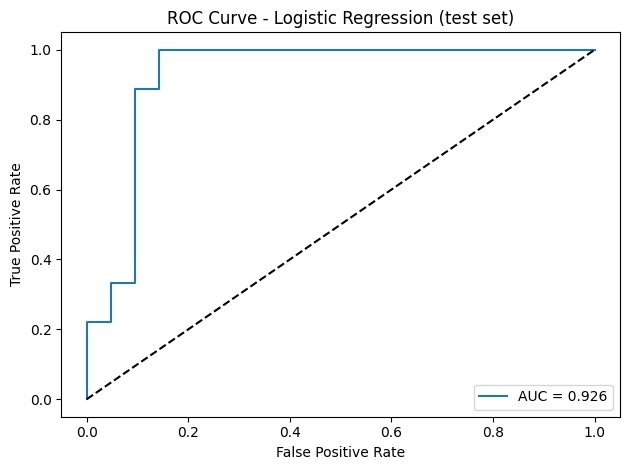

In [26]:
# logistic regression with sklearn (ML style)
log_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
log_clf.fit(X_train_scaled, y_train)

y_train_pred = log_clf.predict(X_train_scaled)
y_test_pred = log_clf.predict(X_test_scaled)

print("==== Logistic Regression (sklearn, 4 features) ====")
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test  accuracy:", accuracy_score(y_test, y_test_pred))

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

y_test_prob = log_clf.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_test_prob)
print("\nTest AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (test set)")
plt.legend()
plt.tight_layout()
plt.show()